## Using Julia and PyCall to analyze public attention to deceased celebrities in early 2021

This is a tutorial on Julia for data science. The following content is about how to use Julia and PyCall to obtain data from Google Trends about five celebrities who died in early 2021. We then analyze the data with StatsPlots.jl. 

First, load the packages and set the number of lines you want to display. 

In [28]:
using DataFrames, CSV, Dates, Pandas, Plots, PyCall

In [29]:
ENV["LINES"] = 20
ENV["COLUMNS"] = 1000

1000

I originally want to analyze ten people but it was a little bit complex so I am only analyzing five of them, two males, and three females.

In [30]:
# https://www.insider.com/celebrities-who-have-died-this-year-2021-1
name = ["Hank Aaron", "Ed Asner", "Sonny Chiba", "Halyna Hutchins", "Cloris Leachman", "Helen McCrory", 
    "Prince Philip", "Christopher Plummer", "Tanya Roberts", "Cicely Tyson"]
gender = ["male", "male", "male", "female", "female", "female", "male", "male", "female", "female"]
death_date = ["2021-01-22", "2021-08-29", "2021-08-19", "2021-10-21", "2021-01-27", "2021-04-16",
    "2021-04-09", "2021-02-05", "2021-01-04", "2021-01-28"
]
df = DataFrames.DataFrame(:name => name, :gender => gender, :death => death_date)
df = df[[1, 5, 8, 9, 10], :]

,name,gender,death
,String,String,String
1,Hank Aaron,male,2021-01-22
2,Cloris Leachman,female,2021-01-27
3,Christopher Plummer,male,2021-02-05
4,Tanya Roberts,female,2021-01-04
5,Cicely Tyson,female,2021-01-28


Now we use `PyCall` to import `pytrends`, since there is no such package for Julia now, unfortunately. 

In [31]:
TrendReq = pyimport("pytrends.request").TrendReq
pytrends = TrendReq(hl="en-US", tz=360)
pytrends.build_payload(df.name, timeframe="2020-12-01 2021-08-01")

In [32]:
# To remove the column of `isPartial`
trends_data = pytrends.interest_over_time().drop("isPartial", 1)

,Hank Aaron,Cloris Leachman,Christopher Plummer,Tanya Roberts,Cicely Tyson
date,,,,,
2020-12-01,0,0,0,0,0
2020-12-02,0,0,0,0,0
2020-12-03,0,0,0,0,0
2020-12-04,0,0,0,0,0
2020-12-05,0,0,1,0,0
...,...,...,...,...,...
2021-07-28,0,0,0,0,0
2021-07-29,0,0,0,0,0
2021-07-30,0,0,0,0,0


Next, we first convert the above data into a Pandas dataframe, which is later converted to a DataFrames dataframe, named as `jdf`. We then transform `jdf` to a tidy format, and named the output as `jdf_tidy`. 

In [33]:
trends = Pandas.reset_index(Pandas.DataFrame(trends_data))
jdf = DataFrames.DataFrame(trends)
jdf_tidy = DataFrames.stack(jdf, 2:6)
rename!(jdf_tidy, [:date, :name, :interest])

,date,name,interest
,DateTime,Cat…,Int64
1,2020-12-01T00:00:00,Hank Aaron,0
2,2020-12-02T00:00:00,Hank Aaron,0
3,2020-12-03T00:00:00,Hank Aaron,0
4,2020-12-04T00:00:00,Hank Aaron,0
5,2020-12-05T00:00:00,Hank Aaron,0
6,2020-12-06T00:00:00,Hank Aaron,0
7,2020-12-07T00:00:00,Hank Aaron,0
8,2020-12-08T00:00:00,Hank Aaron,0
9,2020-12-09T00:00:00,Hank Aaron,0


Now, we create two dictionaries for gender and death_date. We need these two dictionaries to fill up two empty columns (for gender and death_date) we are going to create. 

In [34]:
jdf_tidy.date = Date.(jdf_tidy.date)
gender_dict = Dict(Pair.(df.name, df.gender))
death_dict = Dict(Pair.(df.name, df.death))

Dict{String, String} with 5 entries:
  "Cloris Leachman"     => "2021-01-27"
  "Tanya Roberts"       => "2021-01-04"
  "Cicely Tyson"        => "2021-01-28"
  "Hank Aaron"          => "2021-01-22"
  "Christopher Plummer" => "2021-02-05"

In [35]:
# To create two empty columns for `gender` and `death_date`:
jdf_tidy[:, :gender] = Vector{String}(undef, size(jdf_tidy)[1])
jdf_tidy[:, :death_date] = Vector{Date}(undef, size(jdf_tidy)[1])

1220-element Vector{Date}:
 -147105041040489-18085043209519162-3689348814741910324
 138772826741951--18085043209519155-3689348814741910305
 176058266421181--42198434155544712-3689348814741910319
 -184051530908095--24113390946025547-7378697629483820638
 131822089246799--18085043209519161-3689348814741910309
 -132043185343785-42198434155544718-3689348814741910348
 23640804498135--12056695473012768-7378697629483820643
 -185690920665950-08-7378697629483820672
 ⋮
 19458606317606-02-13
 384851639533-06-19
 384851639533-03-15
 16382822-05-21
 8477551716383-02-05
 384851639532-07-02
 384851639533-04-16

As mentioned above, we iterate each row in `jdf_tidy` and fill up the two empty columns with the two dictionaries.

In [36]:
for r in eachrow(jdf_tidy)
    if r.name in collect(keys(gender_dict))
        r.gender = gender_dict[r.name]
    end
    if r.name in collect(keys(death_dict))
        r.death_date = Date(death_dict[r.name], "yyyy-mm-dd")
    end
end

In [37]:
jdf_tidy

,date,name,interest,gender,death_date
,Date,Cat…,Int64,String,Date
1,2020-12-01,Hank Aaron,0,male,2021-01-22
2,2020-12-02,Hank Aaron,0,male,2021-01-22
3,2020-12-03,Hank Aaron,0,male,2021-01-22
4,2020-12-04,Hank Aaron,0,male,2021-01-22
5,2020-12-05,Hank Aaron,0,male,2021-01-22
6,2020-12-06,Hank Aaron,0,male,2021-01-22
7,2020-12-07,Hank Aaron,0,male,2021-01-22
8,2020-12-08,Hank Aaron,0,male,2021-01-22
9,2020-12-09,Hank Aaron,0,male,2021-01-22


Now, we create another column named `distance`, which is the **distance** between the each date and the celebrity's `death_date`.

In [38]:
function getDayValue(a, b)
    (a - b).value
end

getDayValue (generic function with 1 method)

In [39]:
jdf_tidy.distance = getDayValue.(jdf_tidy.date, jdf_tidy.death_date) 
jdf_tidy

,date,name,interest,gender,death_date,distance
,Date,Cat…,Int64,String,Date,Int64
1,2020-12-01,Hank Aaron,0,male,2021-01-22,-52
2,2020-12-02,Hank Aaron,0,male,2021-01-22,-51
3,2020-12-03,Hank Aaron,0,male,2021-01-22,-50
4,2020-12-04,Hank Aaron,0,male,2021-01-22,-49
5,2020-12-05,Hank Aaron,0,male,2021-01-22,-48
6,2020-12-06,Hank Aaron,0,male,2021-01-22,-47
7,2020-12-07,Hank Aaron,0,male,2021-01-22,-46
8,2020-12-08,Hank Aaron,0,male,2021-01-22,-45
9,2020-12-09,Hank Aaron,0,male,2021-01-22,-44


In [40]:
using StatsPlots

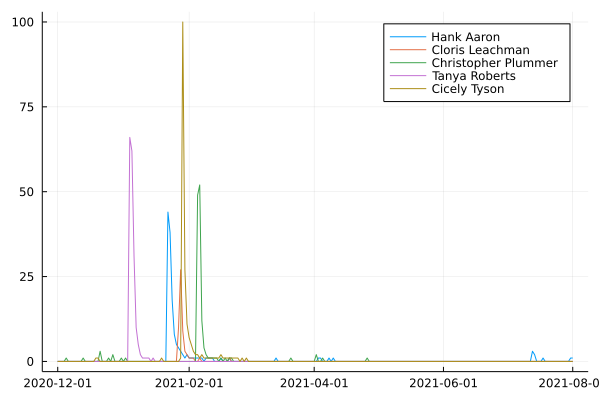

In [41]:
@df jdf_tidy Plots.plot(:date, :interest, group=:name,
    seriestype=:line, fmt = :png
)

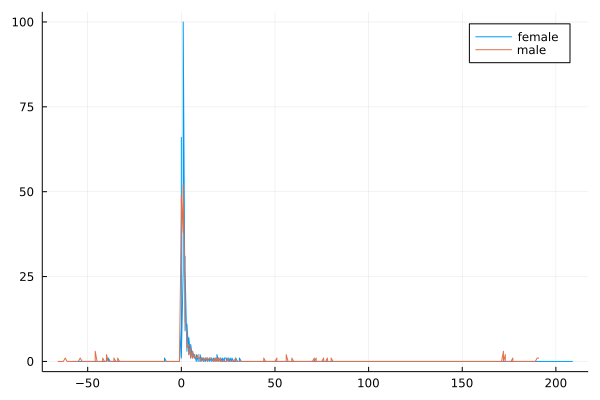

In [42]:
@df jdf_tidy Plots.plot(:distance, :interest, group=:gender,
    seriestype=:line, fmt = :png
)

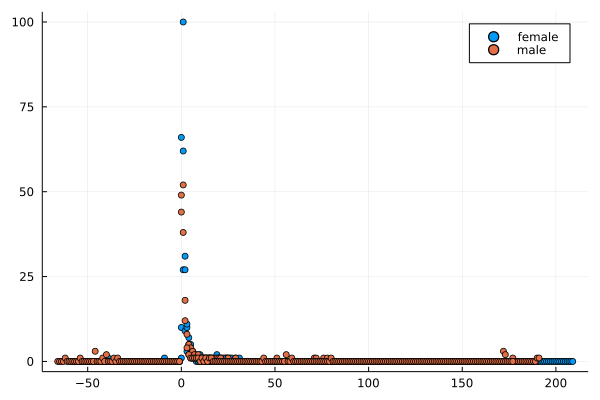

In [43]:
@df jdf_tidy Plots.plot(:distance, :interest, group=:gender,
    seriestype=:scatter, fmt = :png
)

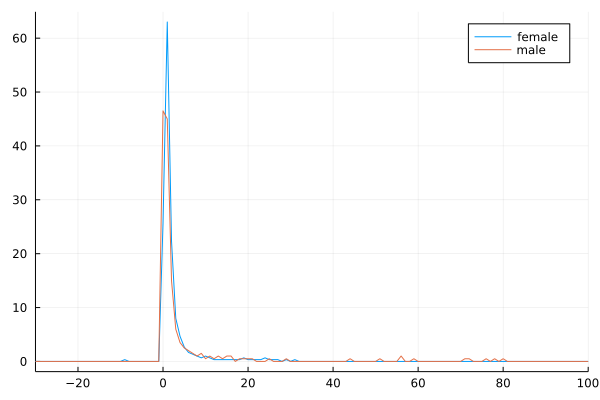

In [44]:
@df df_plots Plots.plot(:distance, :interest_mean, group=:gender,
    seriestype=:line,
    xlim=(-30, 100),
    fmt = :png
)

In [45]:
df_new = jdf_tidy[:, [:interest, :gender, :distance]]
gdf = DataFrames.groupby(df_new, [:gender, :distance])
df_plots = combine(gdf, :interest => mean)

,gender,distance,interest_mean
,String,Int64,Float64
1,male,-52,0.0
2,male,-51,0.0
3,male,-50,0.0
4,male,-49,0.0
5,male,-48,0.0
6,male,-47,0.0
7,male,-46,1.5
8,male,-45,0.0
9,male,-44,0.0
